In [101]:
%cd /scratch/bruingjde/SNAM2021-code/

from constants import *

/scratch/bruingjde/SNAM2021-code


# Edge temporal features

In [102]:
def logistic_regression(X, y):
  X_train, X_test, y_train, y_test = (
    sklearn.model_selection.train_test_split(X, y))
  pipe = sklearn.pipeline.make_pipeline(
    sklearn.preprocessing.StandardScaler(),
    sklearn.linear_model.LogisticRegression(max_iter=10000, n_jobs=-1))
  pipe.fit(X_train, y_train)
  
  auc = sklearn.metrics.roc_auc_score(
    y_true=y_test, y_score=pipe.predict_proba(X_test)[:,1])
  
  return auc

class FeatureSet(typing.NamedTuple):
  time: str
  heuristic: str
  network: int

def get_features() -> dict[FeatureSet, typing.Union[np.ndarray, pd.DataFrame]]:
  aggregation_strategies = ['m0', 'm1', 'q0', 'q25', 'q50', 'q75', 'q100']
  # Get all features that will be used in the logistic_regression.
  # Start with the static ones. For each heuristic:
  features = {
    FeatureSet('static', heuristic, network_index): np.load(
      f'data/{network_index:02}/features/time_agnostic/{heuristic}.npy'
    ).reshape(-1,1)
    for heuristic in heuristics for network_index in network_indices
  }
  # Still static, but all heuristics combined:
  for network_index in network_indices:
    features[FeatureSet('static', 'combined', network_index)] = pd.DataFrame(
      {
        heuristic: np.load(
          f'data/{network_index:02}/features/time_agnostic/{heuristic}.npy')
        for heuristic in heuristics
      }
    )
    # Temporal edge, for each time_strategy, for each of the heuristics:
    for time_strategy in time_strategies:
      for heuristic in heuristics:
        if network_index in hypergraph_indices:
          # For each heuristic
          features[FeatureSet(time_strategy, heuristic, network_index)] = (
            pd.DataFrame(
              {
                aggregation_strategy: np.load(
                  f'data/{network_index:02}/features/time_edge/'
                  f'{heuristic}_{time_strategy}_{aggregation_strategy}.npy')
                for aggregation_strategy in aggregation_strategies
              }
            )
          )
          # Heuristics combined
          features[FeatureSet(time_strategy, 'combined', network_index)] = (
            pd.DataFrame(
              {
                (heuristic, aggregation_strategy): np.load(
                  f'data/{network_index:02}/features/time_edge/'
                  f'{heuristic}_{time_strategy}_{aggregation_strategy}.npy')
                for aggregation_strategy in aggregation_strategies
                for heuristic in heuristics
              }
            )
          )
        else: # No hypergraph
          # For each heuristic
          features[FeatureSet(time_strategy, heuristic, network_index)] = (
            np.load(
              f'data/{network_index:02}/features/time_edge/'
              f'{heuristic}_{time_strategy}.npy'
            ).reshape(-1,1)
          )
          # Heuristics combined
          features[FeatureSet(time_strategy, 'combined', network_index)] = (
            pd.DataFrame(
              {
                heuristic: np.load(f'data/{network_index:02}/features/'
                                   f'time_edge/{heuristic}_{time_strategy}.npy')
                for heuristic in heuristics
              }
            )
          )
    # Temporal edge, all time_strategies combined, but per heuristic:
    for heuristic in heuristics:
      if network_index in hypergraph_indices:
        # For each heuristic
        features[FeatureSet('combined', heuristic, network_index)] = (
          pd.DataFrame(
            {
              aggregation_strategy: np.load(
                f'data/{network_index:02}/features/time_edge/'
                f'{heuristic}_{time_strategy}_{aggregation_strategy}.npy')
              for aggregation_strategy in aggregation_strategies
              for time_strategy in time_strategies
            }
          )
        )
        # Heuristics combined
        features[FeatureSet('combined', 'combined', network_index)] = (
          pd.DataFrame(
            {
              (heuristic, aggregation_strategy): np.load(
                f'data/{network_index:02}/features/time_edge/'
                f'{heuristic}_{time_strategy}_{aggregation_strategy}.npy')
              for aggregation_strategy in aggregation_strategies
              for time_strategy in time_strategies
              for heuristic in heuristics
            }
          )
        )
      else: # No hypergraph
        # For each heuristic
        features[FeatureSet('combined', heuristic, network_index)] = (
          pd.DataFrame(
            {
              heuristic: np.load(f'data/{network_index:02}/features/time_edge/'
                                 f'{heuristic}_{time_strategy}.npy')
              for time_strategy in time_strategies
            }
          )
        )

        # Heuristics combined
        features[FeatureSet('combined', 'combined', network_index)] = pd.DataFrame(
          {
            heuristic: np.load(f'data/{network_index:02}/features/time_edge/'
                               f'{heuristic}_{time_strategy}.npy')
            for heuristic in heuristics
            for time_strategy in time_strategies
          }
        )
  return features

In [103]:
featuresets = get_features()

In [109]:
auc_featuresets = [
  {
    'auc': logistic_regression(
      X=featureset, 
      y=np.load(f'data/{featureset_id.network:02}/targets_sampled.npy')),
    **featureset_id._asdict()
  }
  for featureset_id, featureset in tqdm(featuresets.items())
]

  0%|          | 0/650 [00:00<?, ?it/s]

In [94]:
df = pd.DataFrame(auc_featuresets.keys())
df['auc'] = auc_featuresets.values()
df

,time,heuristic,network,auc
0,static,aa,1,0.695153
1,static,aa,2,0.777211
2,static,aa,3,0.826464
3,static,aa,4,0.740360
4,static,aa,5,0.651698
...,...,...,...,...
645,combined,aa,30,0.832486
646,combined,combined,30,0.846528
647,combined,cn,30,0.832227
648,combined,jc,30,0.808217


In [142]:
auc_table = (
  df
  .groupby(['time', 'heuristic'])['auc']
  .mean()
  .unstack()
  .loc[['static', 'lin', 'exp', 'sqrt', 'combined']]
  .sort_values('static', axis='columns'))

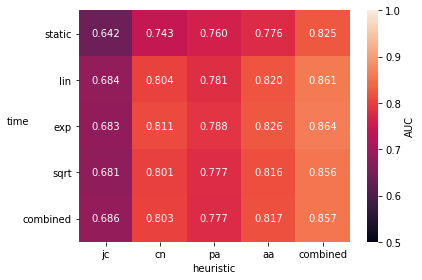

In [143]:
g = sns.heatmap(auc_table, annot=True, vmin=.5, vmax=1, fmt='.3f',
                cbar_kws=dict(label='AUC'))
g.set_yticklabels(g.get_yticklabels(), rotation = 0);
g.set_ylabel(g.get_ylabel(), rotation=0)
plt.tight_layout()
plt.savefig('figures/table-time-strategies.pdf')